# Upload data

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GOOG.csv to GOOG.csv
User uploaded file "GOOG.csv" with length 294817 bytes


# Import data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
LAG_DAYS = 21

In [0]:
data = pd.read_csv('GOOG.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


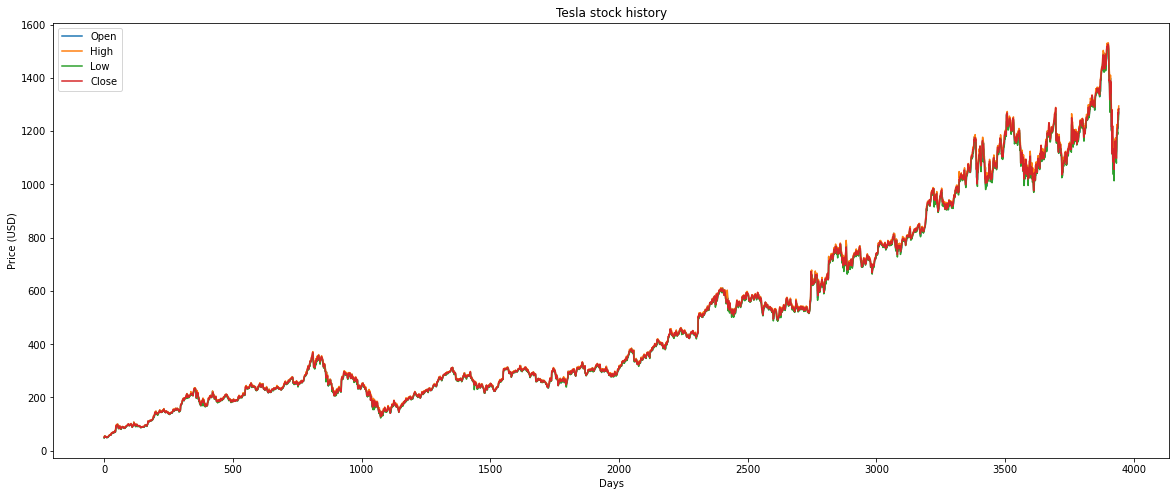

In [0]:
plt.figure(figsize=(20, 8))

plt.plot(data['Open'])
plt.plot(data['High'])
plt.plot(data['Low'])
plt.plot(data['Close'])
plt.title('Tesla stock history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'High', 'Low', 'Close'])

plt.show()

# Preprocessing data

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [0]:
def split_feature_target( data, target_index, lag_days):

  """
  Split data into lag_days days for feature and next day for prediction
  Arguments:
      data {[np.array]} -- [array of data to split]
      target_index {[int]} -- [index of target column]
      lag_days {[int]} -- [number of days to be used to make prediction]

  Returns:
      [X, y] -- [array of days lag_days prior and next day stock price]
  """

  X = np.array([data[i: i + lag_days].copy() for i in range(len(data) - lag_days)])
  y = np.array([data[i + lag_days][target_index].copy() for i in range(len(data) - lag_days)])
  y = np.expand_dims(y, axis=1)

  return (X, y)

In [0]:
def split_train_test_set(data, feature_cols, train_ratio=0.8):
        
  """
  Split to data to train, test set
  Arguments:
      data {[np.array or pd.DataFrame]} -- [dataset to split]
      feature_cols {[list]} -- [columns to be used as feature]
      train_ratio {float} -- [train_size ratio] (default: {0.8})
  Returns:
      [train_set, test_set] -- [train set and test set]
  """
  X = data.loc[:, feature_cols].values
  num_train_instances = int(X.shape[0] * train_ratio)
  train_set = X[:num_train_instances]
  test_set = X[num_train_instances:]

  return (train_set, test_set)

In [0]:
def scale_data(data, scaler=None):
        
  """
  Transform data by scaling each column to a given range (0 and 1)
  Arguments:
      data {[np.array]} -- [array of feature or target for stock prediction]
      scaler {[type]} -- [if scaler is provided then use that scaler to scale data, or create new scaler otherwise] (default: {None})
  Returns:
      [data_scaled, scaler] -- [scaled data and its scaler]
  """

  if scaler is None:
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
  else:
    data_scaled = scaler.transform(data)

  return data_scaled, scaler

In [0]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
train_set, test_set = split_train_test_set(data=data, feature_cols=feature_cols, train_ratio=0.8)

# for inversing prediction to actual value
_, target_scaler = scale_data(np.reshape(train_set[:, 3], (-1, 1)))
X_train_scaled, feature_scaler = scale_data(train_set)
X_test_scaled, _ = scale_data(test_set, feature_scaler)

X_train, y_train = split_feature_target(X_train_scaled, 3, lag_days=LAG_DAYS)
X_test, y_test = split_feature_target(X_test_scaled, 3, lag_days=LAG_DAYS)

In [0]:
print(f'Training set: ({X_train.shape} - {y_train.shape})')
print(f'Testing set: ({X_test.shape} - {y_test.shape})')

Training set: ((3133, 21, 5) - (3133, 1))
Testing set: ((768, 21, 5) - (768, 1))


# Predict 1 day ahead

## Creating the model

In [0]:
import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, concatenate, Input
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(40, input_shape=(LAG_DAYS, 5)))
lstm_model.add(Dense(32, activation='elu'))
lstm_model.add(Dense(1, activation='relu'))
lstm_model.compile(loss='mse', optimizer='adam')

In [0]:
history = lstm_model.fit(x=X_train, y=y_train, epochs=50, batch_size=32, verbose=2, shuffle=True, validation_split=0.2)

Epoch 1/50
79/79 - 1s - loss: 0.0055 - val_loss: 0.0067
Epoch 2/50
79/79 - 1s - loss: 1.9422e-04 - val_loss: 5.3544e-04
Epoch 3/50
79/79 - 1s - loss: 1.2836e-04 - val_loss: 5.2645e-04
Epoch 4/50
79/79 - 1s - loss: 1.2254e-04 - val_loss: 4.4052e-04
Epoch 5/50
79/79 - 1s - loss: 1.1605e-04 - val_loss: 4.1796e-04
Epoch 6/50
79/79 - 1s - loss: 1.1228e-04 - val_loss: 6.1296e-04
Epoch 7/50
79/79 - 1s - loss: 1.1437e-04 - val_loss: 5.0612e-04
Epoch 8/50
79/79 - 1s - loss: 1.0487e-04 - val_loss: 7.2770e-04
Epoch 9/50
79/79 - 1s - loss: 1.0308e-04 - val_loss: 3.9802e-04
Epoch 10/50
79/79 - 1s - loss: 1.0362e-04 - val_loss: 3.5683e-04
Epoch 11/50
79/79 - 1s - loss: 9.9026e-05 - val_loss: 3.7885e-04
Epoch 12/50
79/79 - 1s - loss: 9.1969e-05 - val_loss: 3.5366e-04
Epoch 13/50
79/79 - 1s - loss: 9.8415e-05 - val_loss: 3.3783e-04
Epoch 14/50
79/79 - 1s - loss: 9.1165e-05 - val_loss: 3.8252e-04
Epoch 15/50
79/79 - 1s - loss: 8.7309e-05 - val_loss: 3.3325e-04
Epoch 16/50
79/79 - 1s - loss: 8.9681e-05 

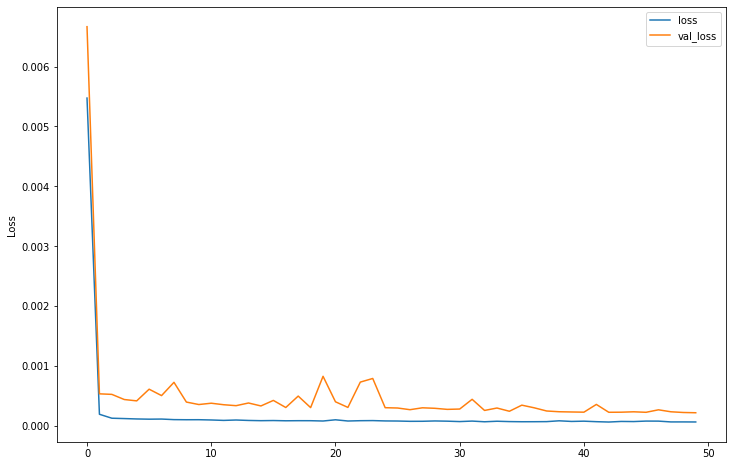

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.show()

## Evaluating the model

In [0]:
lstm_model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 3ms/step - loss: 0.0018


0.0018451007781550288

In [0]:
y_predicted = lstm_model.predict(X_test)
y_predicted_inverse = target_scaler.inverse_transform(y_predicted)
y_test_inverse = target_scaler.inverse_transform(y_test)

mae_inverse = np.sum(np.abs(y_predicted_inverse - y_test_inverse)) / len(y_test)
print(f'Mean Absolute Error - Testing = {mae_inverse}')

Mean Absolute Error - Testing = 27.114501791920983


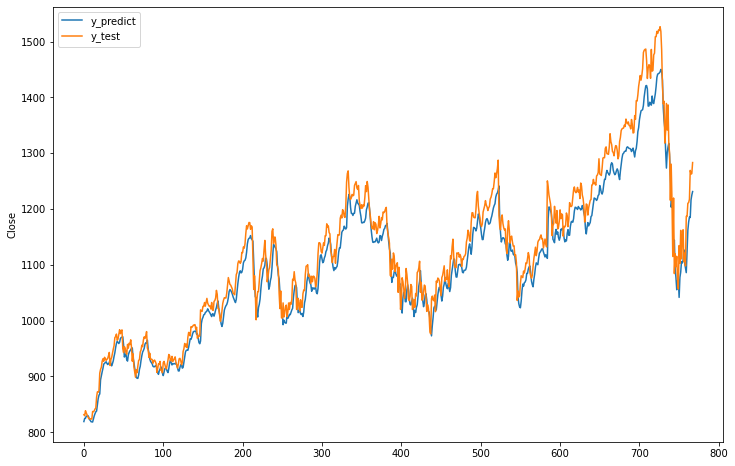

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(y_predicted_inverse)
plt.plot(y_test_inverse)
plt.ylabel('Close')
plt.legend(['y_predict', 'y_test'])

plt.show()

# Using Moving-Average as extensive feature

In [0]:
X_train_ma = np.mean(X_train, axis=1)
X_test_ma = np.mean(X_test, axis=1)

In [0]:
print(f'Extensive training MA: ({X_train_ma.shape})')
print(f'Extensive testing MA: ({X_test_ma.shape})')

Extensive training MA: ((3133, 5))
Extensive testing MA: ((768, 5))


In [0]:
lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(40)(lstm_input)

extensive_input = Input(shape=(X_train_ma.shape[1]))
dense_extensive_layer = Dense(20, activation='elu')(extensive_input)

lstm_output = concatenate((dense_extensive_layer, lstm_layer))
dense_layer = Dense(32, activation='elu')(lstm_output)
output_layer = Dense(1, activation='relu')(dense_layer)

lstm_model = Model(inputs=[lstm_input, extensive_input], outputs=output_layer)
lstm_model.compile(loss='mse', optimizer='adam')

In [0]:
history = lstm_model.fit(x=[X_train, X_train_ma], y=y_train, epochs=50, batch_size=32, verbose=2, shuffle=True, validation_split=0.2)

Epoch 1/50
79/79 - 1s - loss: 0.0073 - val_loss: 0.0059
Epoch 2/50
79/79 - 1s - loss: 3.6699e-04 - val_loss: 0.0023
Epoch 3/50
79/79 - 1s - loss: 2.9411e-04 - val_loss: 0.0022
Epoch 4/50
79/79 - 1s - loss: 2.6085e-04 - val_loss: 0.0013
Epoch 5/50
79/79 - 1s - loss: 2.2549e-04 - val_loss: 6.7625e-04
Epoch 6/50
79/79 - 1s - loss: 2.1079e-04 - val_loss: 5.5348e-04
Epoch 7/50
79/79 - 1s - loss: 1.7731e-04 - val_loss: 8.0733e-04
Epoch 8/50
79/79 - 1s - loss: 1.7194e-04 - val_loss: 4.6925e-04
Epoch 9/50
79/79 - 1s - loss: 1.4255e-04 - val_loss: 4.8311e-04
Epoch 10/50
79/79 - 1s - loss: 1.3562e-04 - val_loss: 5.4333e-04
Epoch 11/50
79/79 - 1s - loss: 1.2124e-04 - val_loss: 3.6195e-04
Epoch 12/50
79/79 - 1s - loss: 9.7608e-05 - val_loss: 3.3442e-04
Epoch 13/50
79/79 - 1s - loss: 1.0213e-04 - val_loss: 3.1849e-04
Epoch 14/50
79/79 - 1s - loss: 9.7377e-05 - val_loss: 3.0227e-04
Epoch 15/50
79/79 - 1s - loss: 1.0127e-04 - val_loss: 3.2584e-04
Epoch 16/50
79/79 - 1s - loss: 9.3585e-05 - val_loss: 

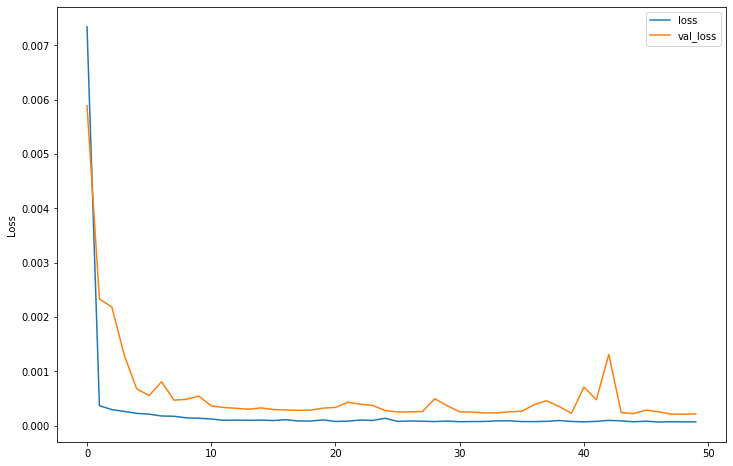

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate([X_test, X_test_ma], y_test)

24/24 [==============================] - 0s 4ms/step - loss: 0.0043


0.004265373107045889

In [0]:
y_predicted = lstm_model.predict([X_test, X_test_ma])
y_predicted_inverse = target_scaler.inverse_transform(y_predicted)
y_test_inverse = target_scaler.inverse_transform(y_test)

mae_inverse = np.sum(np.abs(y_predicted_inverse - y_test_inverse)) / len(y_test)
print(f'Mean Absolute Error - Testing = {mae_inverse}')

Mean Absolute Error - Testing = 41.69802515019226


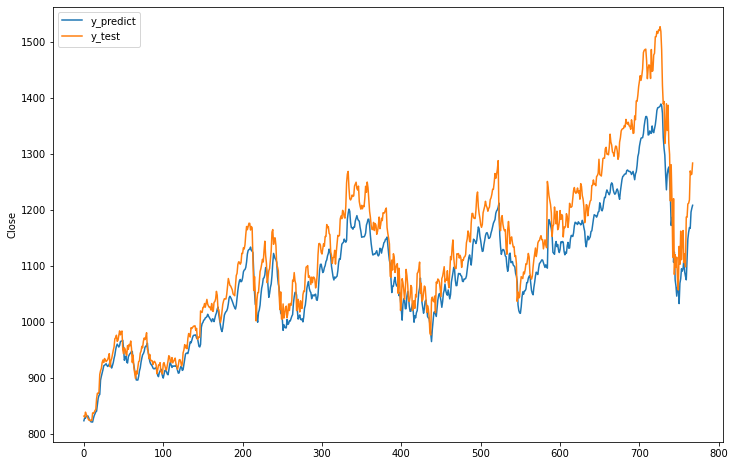

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(y_predicted_inverse)
plt.plot(y_test_inverse)
plt.ylabel('Close')
plt.legend(['y_predict', 'y_test'])

plt.show()

# Fine-tuning model

The model with Moving Average performs better on 5 fits compared to model without Moving Average. Hence, we will use Moving Average in our final model and fine-tuning it.

In [0]:
lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(40)(lstm_input)

extensive_input = Input(shape=(X_train_ma.shape[1]))
dense_extensive_layer = Dense(20, activation='relu')(extensive_input)

lstm_output = concatenate((dense_extensive_layer, lstm_layer))
dense_layer = BatchNormalization()(lstm_output)

dense_layer = Dense(32, activation='relu')(lstm_output)
output_layer = Dense(1, activation='relu')(dense_layer)

lstm_model = Model(inputs=[lstm_input, extensive_input], outputs=output_layer)
lstm_model.compile(loss='mse', optimizer='adam')

In [0]:
history = lstm_model.fit(x=[X_train, X_train_ma], y=y_train, epochs=120, batch_size=32, verbose=2, shuffle=True, validation_split=0.2)

Epoch 1/120
79/79 - 1s - loss: 0.0111 - val_loss: 0.0027
Epoch 2/120
79/79 - 1s - loss: 1.4790e-04 - val_loss: 0.0018
Epoch 3/120
79/79 - 1s - loss: 1.2914e-04 - val_loss: 0.0023
Epoch 4/120
79/79 - 1s - loss: 1.1818e-04 - val_loss: 0.0015
Epoch 5/120
79/79 - 1s - loss: 1.1140e-04 - val_loss: 0.0014
Epoch 6/120
79/79 - 1s - loss: 1.2259e-04 - val_loss: 0.0011
Epoch 7/120
79/79 - 1s - loss: 1.1292e-04 - val_loss: 0.0016
Epoch 8/120
79/79 - 1s - loss: 1.1342e-04 - val_loss: 7.9959e-04
Epoch 9/120
79/79 - 1s - loss: 1.1092e-04 - val_loss: 0.0015
Epoch 10/120
79/79 - 1s - loss: 1.0542e-04 - val_loss: 9.4008e-04
Epoch 11/120
79/79 - 1s - loss: 1.0897e-04 - val_loss: 0.0017
Epoch 12/120
79/79 - 1s - loss: 1.0780e-04 - val_loss: 0.0017
Epoch 13/120
79/79 - 1s - loss: 1.0067e-04 - val_loss: 0.0013
Epoch 14/120
79/79 - 1s - loss: 9.6591e-05 - val_loss: 0.0011
Epoch 15/120
79/79 - 1s - loss: 1.0619e-04 - val_loss: 0.0013
Epoch 16/120
79/79 - 1s - loss: 9.8855e-05 - val_loss: 6.0089e-04
Epoch 17/

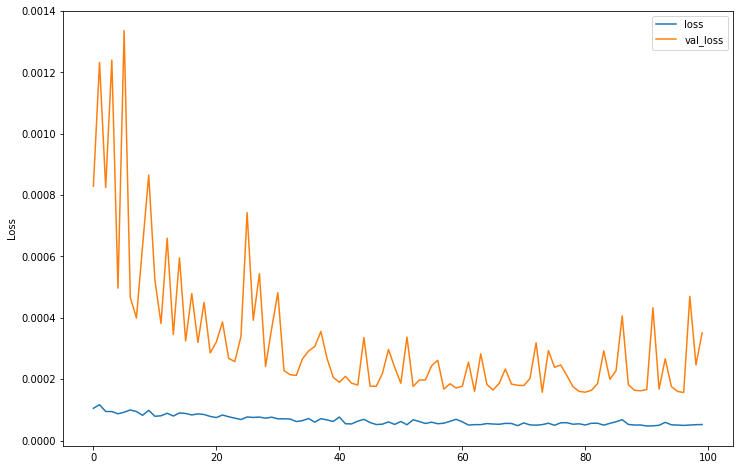

In [0]:
loss = history.history['loss'][20:]
val_loss = history.history['val_loss'][20:]

plt.figure(figsize=(12, 8))

plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

plt.show()

In [0]:
lstm_model.evaluate([X_test, X_test_ma], y_test)

24/24 [==============================] - 0s 3ms/step - loss: 0.0026


0.002626866102218628

In [0]:
y_predicted = lstm_model.predict([X_test, X_test_ma])
y_predicted_inverse = target_scaler.inverse_transform(y_predicted)
y_test_inverse = target_scaler.inverse_transform(y_test)

mae_inverse = np.sum(np.abs(y_predicted_inverse - y_test_inverse)) / len(y_test)
print(f'Mean Absolute Error - Testing = {mae_inverse}')

Mean Absolute Error - Testing = 34.96290262446595


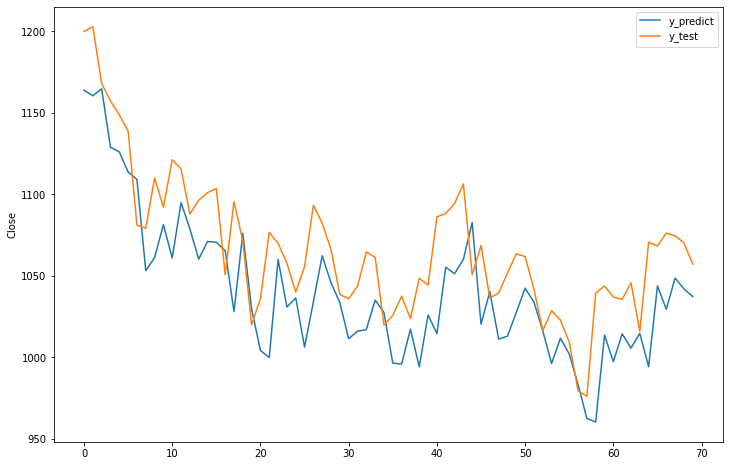

In [0]:
plt.figure(figsize=(12, 8))

plt.plot(y_predicted_inverse[380:450])
plt.plot(y_test_inverse[380:450])
plt.ylabel('Close')
plt.legend(['y_predict', 'y_test'])

plt.show()